#  Basics on scRL 

Scanpy is not necessary for scRL's core functions, we utilize it for data loading and parts of visualization, which can be performed mainly by matplotlib and seaborn.

In [1]:
import scRL
import scanpy as sc
sc.set_figure_params(figsize=(5,5),frameon=False,fontsize=14)

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Preprocessing of the data 

In [2]:
adata = sc.datasets.paul15()
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata,max_value=10)
sc.pp.pca(adata,n_comps=50)
sc.tl.tsne(adata,perplexity=50)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)

 Here we choose the t-SNE output of scanpy as scRL's 2-D embedding and using the leiden clusters as cell annotations.

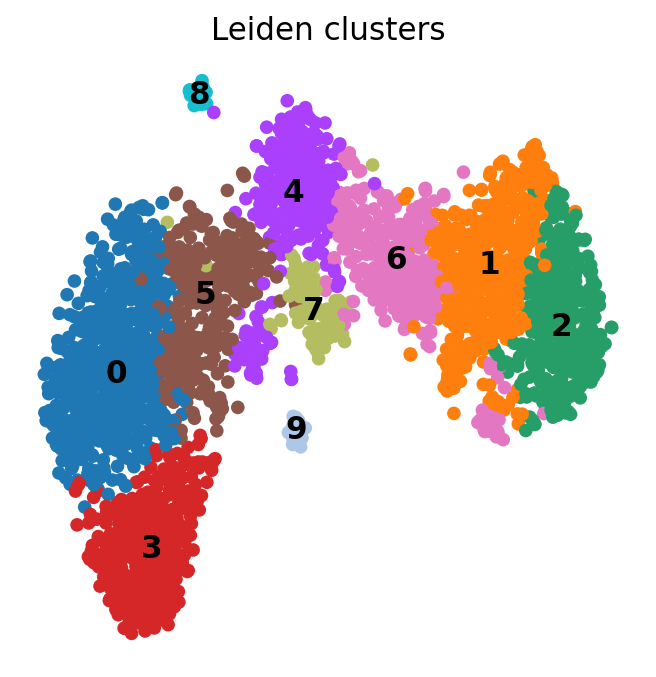

In [3]:
sc.pl.tsne(adata, color='leiden',legend_loc='on data',s=150, title='Leiden clusters')

## scRL's grid embedding and pseudotime alignment functions 

 Getting the necessary information for the initialization of scRL.

In [4]:
X = adata.obsm['X_tsne']

clusters = adata.obs['leiden']

clusters_colors = adata.uns['leiden_colors']

 Generating a grid embedding for the original t-SNE.

In [5]:
gres = scRL.grids_from_embedding(X)

Adjacent generating: 100%|████████████████| 1296/1296 [00:00<00:00, 2796.00it/s]

Time used for mapping grids: 7.42 seconds


 Projecting the annotation information onto the grid embedding space.

In [6]:
scRL.project_cluster(gres, clusters, clusters_colors)

Time used for projecting annotation : 1.15 seconds


 Select cluster 4 as starting points and aligning pseudotime.

In [7]:
scRL.align_pseudotime(gres, '4')

scRL.project_back(gres,'pseudotime')

Time used for aligning pseudo-time : 0.54 seconds


 Plotting the grids embedding.

In [8]:
g = gres.grids['grids'][gres.grids['mapped_grids']]

In [9]:
b = gres.grids['grids'][gres.grids['mapped_boundary']]

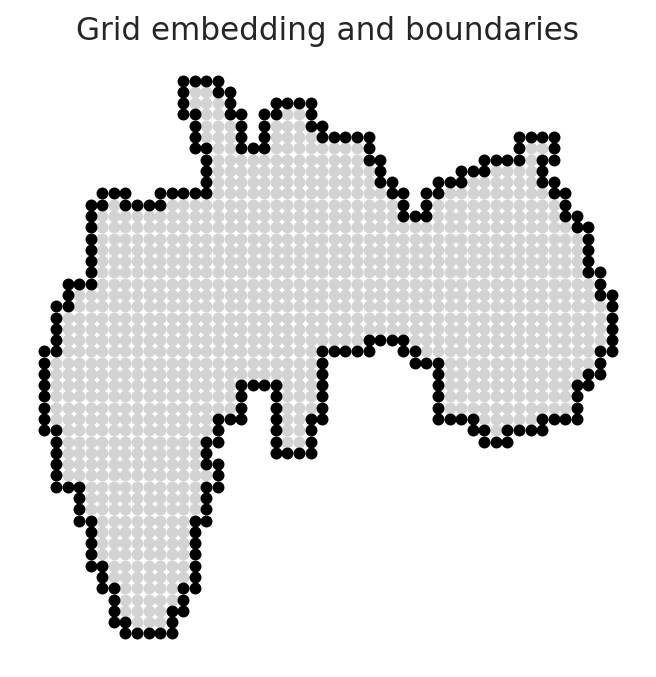

In [10]:
with sns.axes_style('white'):
    plt.scatter(g[:,0], g[:,1], marker='.',s=75,c='lightgrey')
    plt.scatter(b[:,0], b[:,1], marker='.',s=75,c='k')
    ax = plt.gca()
    ax.set_frame_on(False)
    ax.tick_params(labelleft=False, labelbottom=False)
    ax.set_title('Grid embedding and boundaries')

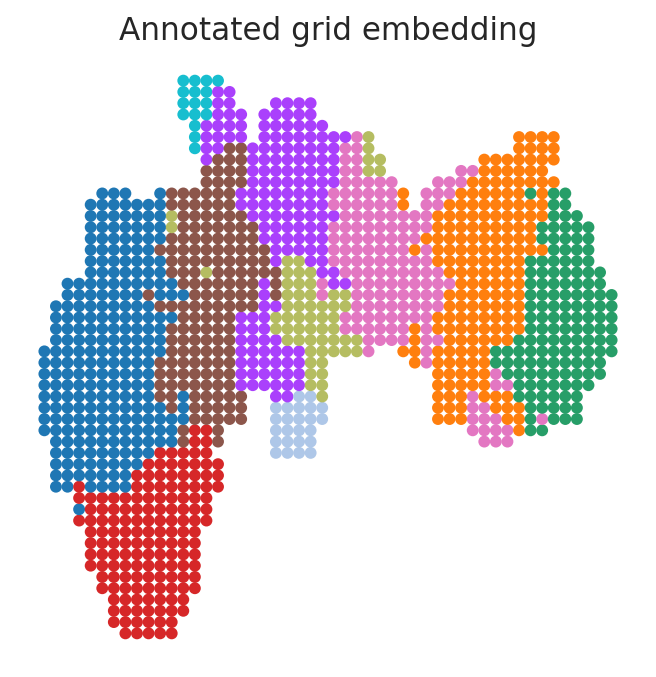

In [11]:
with sns.axes_style('white'):
    plt.scatter(g[:,0], g[:,1], marker='.',s=75,c=gres.grids['mapped_grids_colors'])
    ax = plt.gca()
    ax.set_frame_on(False)
    ax.tick_params(labelleft=False, labelbottom=False)
    ax.set_title('Annotated grid embedding')

In [12]:
adata.obs['scRL_time'] = gres.embedding['pseudotime']

<AxesSubplot: title={'center': 'scRL_time'}, xlabel='tSNE1', ylabel='tSNE2'>

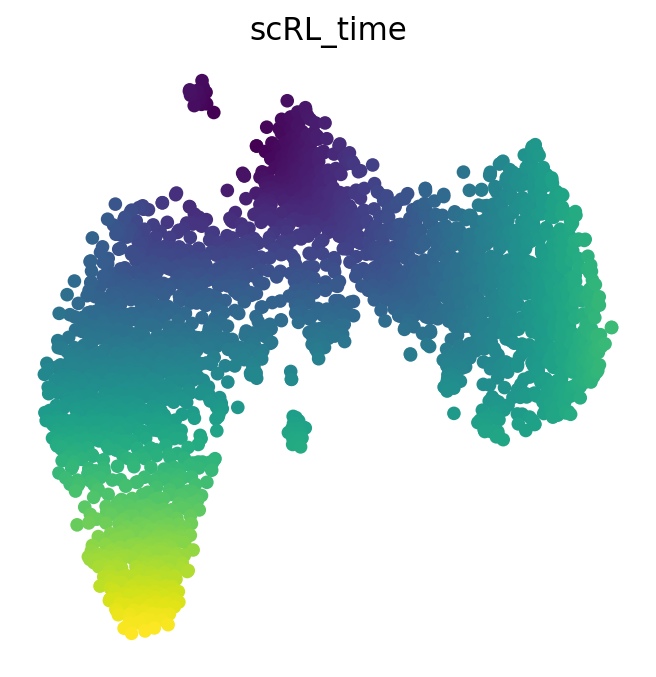

In [13]:
sc.pl.tsne(adata, color='scRL_time', frameon=False,s=150,cmap='viridis',colorbar_loc=None,legend_loc=None,show=False)


<AxesSubplot: title={'center': 'Mpo'}, xlabel='tSNE1', ylabel='tSNE2'>

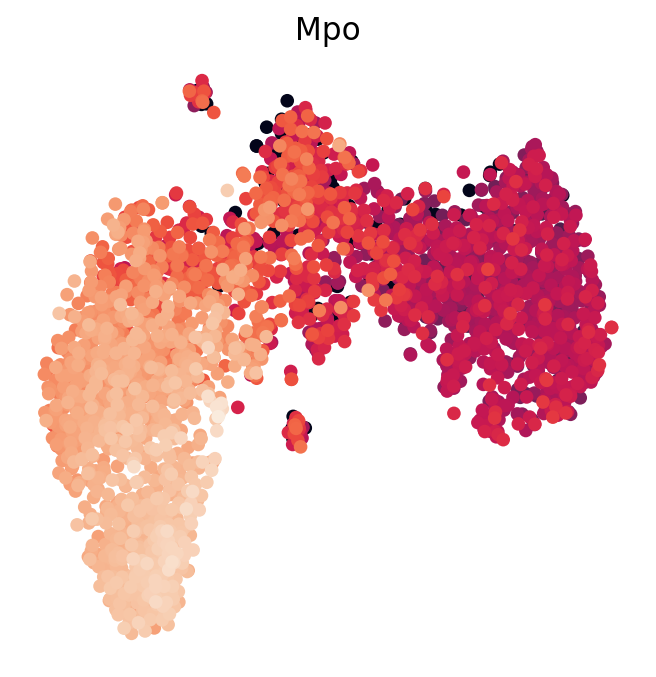

In [14]:
sc.pl.tsne(adata, color='Mpo', frameon=False,s=150,cmap='rocket',colorbar_loc=None,legend_loc=None,show=False)


In [15]:
exp = pd.DataFrame(adata[:,['Mpo','Klf1']].X,columns=['Mpo','Klf1'])

In [16]:
scRL.project_expression(gres, exp)

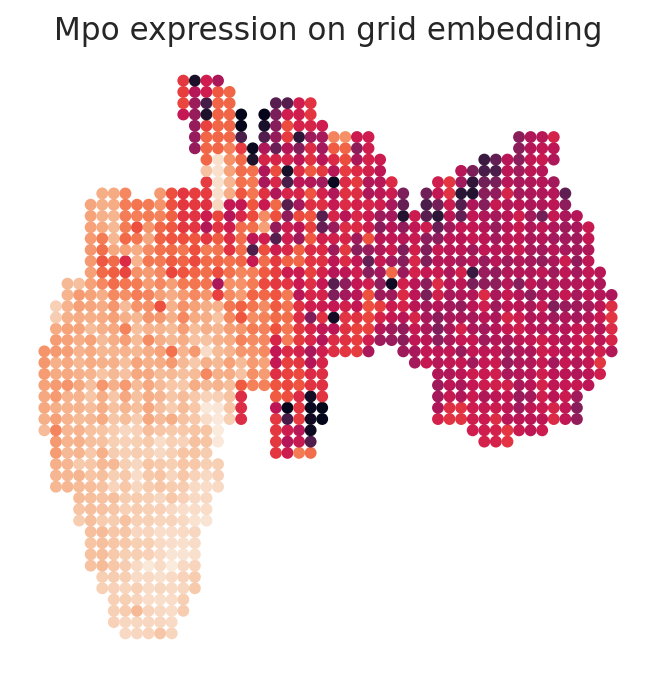

In [17]:
with sns.axes_style('white'):
    plt.scatter(g[:,0], g[:,1], marker='.',s=75, c=gres.grids['gene_exp']['Mpo'])
    ax = plt.gca()
    ax.set_frame_on(False)
    ax.tick_params(labelleft=False, labelbottom=False)
    ax.set_title('Mpo expression on grid embedding')

## scRL's reward functions 

 Decision reward mode for lineage.

In [18]:
scRL.lineage_rewards(gres, starts='4', ends=['0','3','5'], mode='Decision')

Reward generating: 100%|██████████████████| 1296/1296 [00:00<00:00, 1900.80it/s]

Time used for generating rewards : 0.71 seconds


In [19]:
import matplotlib as mpl

 Reward generated

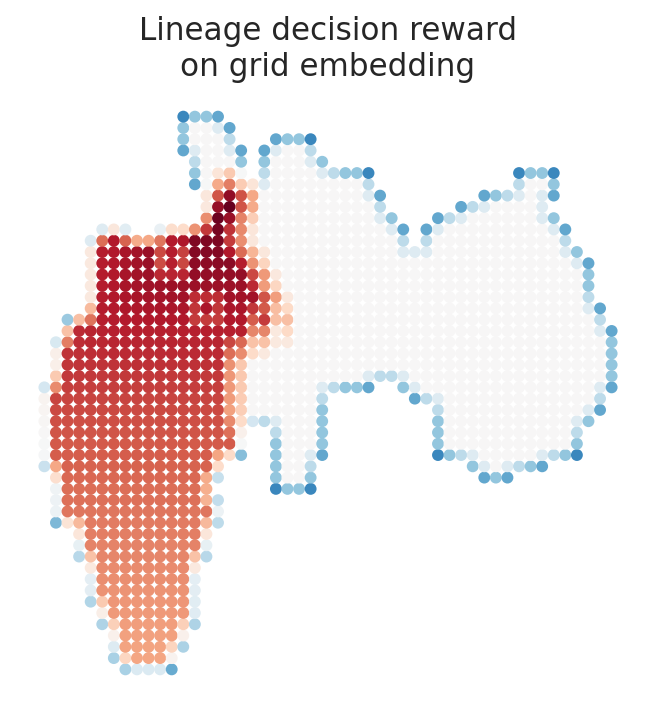

In [20]:
with sns.axes_style('white'):
    plt.scatter(g[:,0], g[:,1], marker='.',s=75, c=gres.qlearning['lineage_Decision_rewards'].sum(axis=1), cmap='RdBu_r', norm=mpl.colors.CenteredNorm())
    ax = plt.gca()
    ax.set_frame_on(False)
    ax.tick_params(labelleft=False, labelbottom=False)
    ax.set_title('Lineage decision reward\non grid embedding')

## Training functions 

 Fetching the PC space for constructing environment and feed the network

In [21]:
X_pca = adata.obsm['X_pca']

In [22]:
t_mye = scRL.trainer('ActorCritic', gres, X_latent=X_pca, num_episodes=5e3)

r_l, v_l = t_mye.train()

Iteration10: 100%|███████████| 500/500 [00:08<00:00, 57.73it/s, E=5000, R=17.68]


 Get the fate decision state value of myeloid lineage

In [23]:
scRL.get_state_value(gres, t_mye, 'Mye')

In [24]:
scRL.project_back(gres, 'Mye')

In [25]:
adata.obs['Mye'] = gres.embedding['Mye']

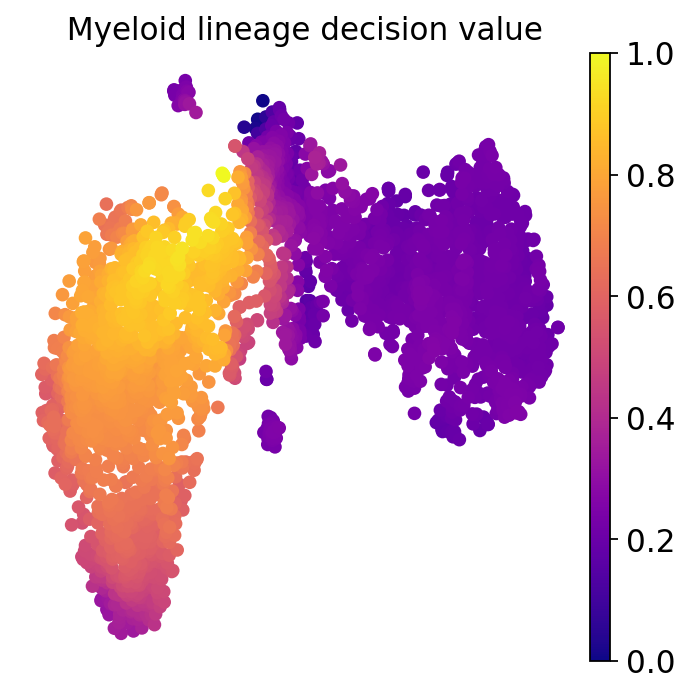

In [26]:
sc.pl.tsne(adata, color='Mye',s=150, cmap='plasma', title=' Myeloid lineage decision value')

 Get the trajectory

In [27]:
scRL.get_traj_df(gres, t_mye, key='Mye')

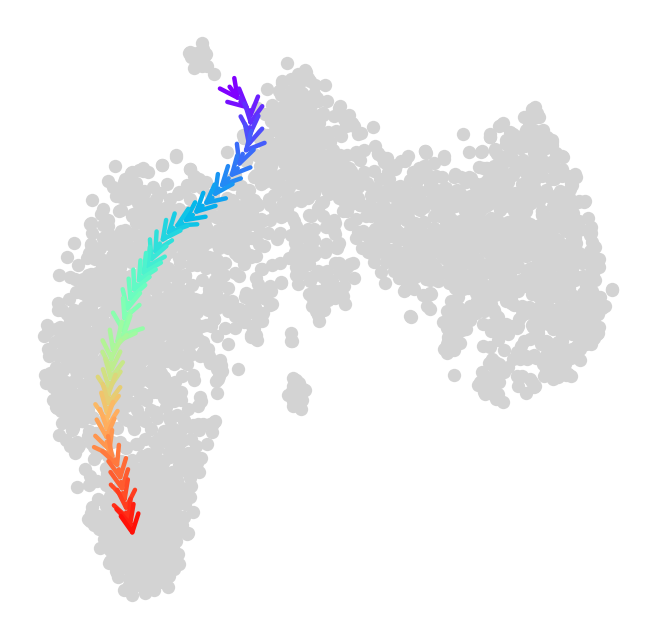

In [28]:
scRL.traj_results(gres, [], 'Mye')